## Exercise 2: Robin Sparticles

- Joao Freitas 
- Dyutideepta Banerjee
- Chelsea Owen 

### Packages

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout 
from keras.optimizers import SGD
import pandas as pd
#dropout: with a given stochastic prob, each neuron is not used. avoids overfitting
import time
import math 

## Making the model

In [29]:
def Keras_NN(len_input, hidden_layers, output_neurons, activation_method, dropout_rate = 0, optimize_method = 'RMSprop', output_activation = 'sigmoid'):
    
    model = Sequential()
    # Input layer
    model.add(Dense(len_input, input_shape = (len_input,), activation = activation_method[0]))
    
    # Hidden layers
    for i in range(hidden_layers):
        model.add(Dense(int(len_input/(2**(i+1))), activation = activation_method[i+1]))
    
    # Drop out layer
    if (dropout_rate != 0):
        model.add(Dropout(dropout_rate))
                  
    # Output layer
    model.add(Dense(output_neurons,activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
              optimizer=optimize_method,
              metrics=['accuracy'])
    
    return model

### Data conversion

In [30]:
def nucleobase_convert(data, base = 4):

#Convert nucleobases to bits
#A = 1000, C = 0100, G = 0010, T = 0001

    no_points = len(data)
    string_len = len(data[0])
    
    Q = ['A', 'C', 'G', 'T']
    onehc = {Q[i]:i for i in range(base)}
    shape = (len(data), len(data[0])*base)
    converted_array = np.zeros(shape)
    for n in range(no_points):
        for i in range(string_len):#4 step for each character
            converted_array[n][i*4 + onehc[data[n][i]]] = 1
    return converted_array

## 16 nucleobase sequence with $N = 3000$

In [31]:
data = pd.read_csv('DATA/sequences16.csv', names = ['sequence', 'label'])
 
X_pre = data['sequence'].to_numpy()
X = nucleobase_convert(X_pre)
y = data['label'].to_numpy()
L = len(X[0])


X_train, X_test = X[:int(len(X)*0.8)], X[int(len(X)*0.8):]
y_train, y_test = y[:int(len(y)*0.8)], y[int(len(y)*0.8):]


model = Keras_NN(L, 2, 1, ['relu', 'relu', 'relu'], dropout_rate = 0.2, optimize_method = 'adam')

We use the same model as in the class, with ReLU activation units in the initial and hidden layers, and sigmoid in the output layer.

In [32]:
fit = model.fit(X, y, verbose=0, validation_split = 0.2, epochs = 50)

Text(0, 0.5, 'Validation')

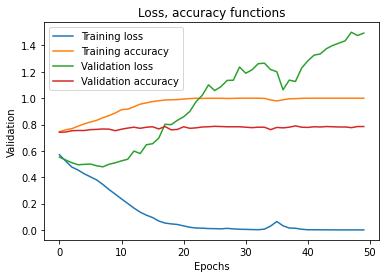

In [33]:
plt.plot(range(len(fit.history['loss'])), fit.history['loss'], label = 'Training loss')
plt.plot(range(len(fit.history['accuracy'])), fit.history['accuracy'], label = 'Training accuracy')


plt.plot(range(len(fit.history['val_loss'])), fit.history['val_loss'], label = 'Validation loss')
plt.plot(range(len(fit.history['val_accuracy'])), fit.history['val_accuracy'], label = 'Validation accuracy')
plt.legend()
plt.title('Loss, accuracy functions')
plt.xlabel('Epochs')
plt.ylabel('Validation')

Validation loss increase suggests the model is overfitting to the training data. The model is not converging with this small database of samples. We need to check if it will perform better with more data. 

## Augmenting data

In [7]:
# Split the data before augmenting, convert the test data
X_train, X_test = X_pre[:round(len(X_pre)*0.8)], nucleobase_convert(X_pre[round(len(X_pre)*0.8):])
y_train, y_test = y[:round(len(y)*0.8)], y[round(len(y)*0.8):]

#Defining a list comprehension that quickly augments the original 3000 point array with all its cyclical permutations
X_aug_pre = np.array([X_train[j][-i:] + X_train[j][:-i] for j in range(len(X_train)) for i in range(len(X_train[j]))])

#Convert the augmented data array; augment the label array accordingly, flattening it
X_aug = nucleobase_convert(X_aug_pre)
y_aug = np.array([[i]*len(X_train[0]) for i in y_train]).flatten()

The augmented data will have some samples with incorrect labels from the augmentation method, we compare the effect of the incorrect labels against having more data.

## Fitting the augmented data to the model from before

In [8]:
fit = model.fit(X_aug, y_aug, verbose=0, validation_data = (X_test, y_test), batch_size = 100, epochs = 50)

Text(0, 0.5, 'Validation')

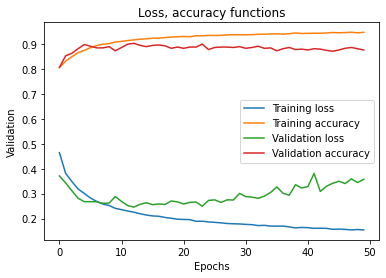

In [9]:
plt.plot(range(len(fit.history['loss'])), fit.history['loss'], label = 'Training loss')
plt.plot(range(len(fit.history['accuracy'])), fit.history['accuracy'], label = 'Training accuracy')

plt.plot(range(len(fit.history['val_loss'])), fit.history['val_loss'], label = 'Validation loss')
plt.plot(range(len(fit.history['val_accuracy'])), fit.history['val_accuracy'], label = 'Validation accuracy')

plt.legend()
plt.title('Loss, accuracy functions')
plt.xlabel('Epochs')
plt.ylabel('Validation')

## Performing a gridsearch for the best parameters

In [10]:
# Monkey-level grid-searching
def gridsearch_NN(x_data, y_labels, x_val, y_val, params, *args):
    from itertools import combinations_with_replacement as combo
    #Set up dataframe to store model info
    
    cols = ['model', 'Activation layer 1', 'Activation layer 2', 'Activation layer 3', 'Drop out rate', 'Optimizer', 'Validation loss', 'Validation accuracy']
    model_list = pd.DataFrame(columns = cols)
    
    #Create list of all possible combos of activation functions for the neuron layers
    activation_list = list(combo(params['activation'], len(params['activation'])))
    
    # Creeate all required model parameters
    L = len(x_data[0])
    no_epochs = 1
    count = 0
    
    for activating_rule in activation_list:
        if np.all(np.where(activating_rule == activating_rule[0], True, False)) == True:
            # executes if all elements in activating_rule are the same.
            for rate in params['dropout rate']:
                for method in params['optimizer']:
                    model = Keras_NN(L, 2, 1, activating_rule, dropout_rate = 0.2, optimize_method = method)
                    fit = model.fit(x_data, y_labels, validation_data = (x_val, y_val), epochs = 1, verbose = 0)
                    count += 1
                    model_params = pd.DataFrame([[count, activating_rule[0], activating_rule[1], activating_rule[2], rate, method, np.max(fit.history['val_loss']), np.max(fit.history['val_accuracy'])]],columns = cols)
                    model_list = pd.concat([model_list, model_params])
        else:
            # executes if each layer uses different activation functions.
            # Then the next line alternates the order in which the functions are applied
            rules_perms = np.array([activating_rule[-i:] + activating_rule[:-i] for i in range(len(activating_rule))])
            for rule_list in rules_perms:
                for rate in params['dropout rate']:
                    for method in params['optimizer']:
                        model = Keras_NN(L, 2, 1, activating_rule, dropout_rate = 0.2, optimize_method = method)
                        fit = model.fit(x_data, y_labels, validation_data = (x_val, y_val), epochs = 1, verbose = 0)
                        count += 1
                        model_params = pd.DataFrame([[count, rule_list[0], rule_list[1], rule_list[2], rate, method, np.max(fit.history['val_loss']), np.max(fit.history['val_accuracy'])]], columns = cols)
                        model_list = pd.concat([model_list, model_params])
    
    model_list = model_list.set_index('model')
    return model_list

In [11]:
params = {
            'activation': ['relu', 'elu', 'sigmoid'],
            'dropout rate': [0.2, 0.4],
            'optimizer': ['adam', 'RMSprop']
         }

model_results = gridsearch_NN(X_aug, y_aug, X_test, y_test, params)
print('Parameters of model with the lowest loss over the validation set: \n')
model_results.loc[model_results['Validation loss'].idxmin()]

Parameters of model with the lowest loss over the validation set: 



Activation layer 1         relu
Activation layer 2          elu
Activation layer 3          elu
Drop out rate               0.2
Optimizer               RMSprop
Validation loss        0.408523
Validation accuracy    0.826667
Name: 38, dtype: object

In [12]:
model_results

,Activation layer 1,Activation layer 2,Activation layer 3,Drop out rate,Optimizer,Validation loss,Validation accuracy
model,,,,,,,
1,relu,relu,relu,0.2,adam,0.432794,0.801667
2,relu,relu,relu,0.2,RMSprop,0.470304,0.785000
3,relu,relu,relu,0.4,adam,0.437588,0.796667
4,relu,relu,relu,0.4,RMSprop,0.454809,0.795000
5,relu,relu,relu,0.2,adam,0.443962,0.795000
...,...,...,...,...,...,...,...
116,sigmoid,sigmoid,sigmoid,0.4,RMSprop,0.497296,0.765000
117,sigmoid,sigmoid,sigmoid,0.2,adam,0.496509,0.760000
118,sigmoid,sigmoid,sigmoid,0.2,RMSprop,0.498199,0.770000


### Rescaling of data using new encoding

In [13]:
def nucleobase_convert_rescaled(data, scale, base = 4):
    no_points = len(data)
    string_len = len(data[0])
    
    Q = ['A', 'C', 'G', 'T']
    onehc = {Q[i]:i for i in range(base)}
    shape = (len(data), len(data[0])*base)
    converted_array = np.zeros(shape)
    converted_array -= scale
    for n in range(no_points):
        for i in range(string_len):#4 step for each character
            converted_array[n][i*4 + onehc[data[n][i]]] = (1-scale)
    return converted_array

In [14]:
#Convert the augmented data array; augment the label array accordingly, flattening it
X_sca = nucleobase_convert_rescaled(X_aug_pre, 0.5)
y_sca = np.array([[i]*len(X_train[0]) for i in y_train]).flatten()

In [34]:
X_sca


model_results = gridsearch_NN(X_sca, y_sca, X_test, y_test, params)
print('Parameters of model with the lowest loss over the validation set: \n')
model_results.loc[model_results['Validation loss'].idxmin()]

Parameters of model with the lowest loss over the validation set: 



Activation layer 1         relu
Activation layer 2          elu
Activation layer 3         relu
Drop out rate               0.2
Optimizer                  adam
Validation loss        0.425435
Validation accuracy       0.805
Name: 21, dtype: object

The new data is scaled with a one hot encoding of [-0.5, 0.5] instead of [0,1] as previously. We define the model with the results of the gridsearch.

In [16]:
# Activation layer 1         relu
# Activation layer 2         relu
# Activation layer 3          elu
# Drop out rate               0.2
# Optimizer                  adam
model2 = Keras_NN(L, 2, 1, ['relu', 'relu', 'elu'], dropout_rate = 0.2, optimize_method = 'adam', output_activation = 'sigmoid')

In [17]:
fit = model2.fit(X_sca, y_sca, verbose=0, validation_data = (X_test, y_test), batch_size = 100, epochs = 50)

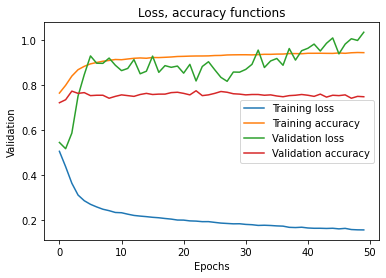

In [18]:
plt.plot(range(len(fit.history['loss'])), fit.history['loss'], label = 'Training loss')
plt.plot(range(len(fit.history['accuracy'])), fit.history['accuracy'], label = 'Training accuracy')

plt.plot(range(len(fit.history['val_loss'])), fit.history['val_loss'], label = 'Validation loss')
plt.plot(range(len(fit.history['val_accuracy'])), fit.history['val_accuracy'], label = 'Validation accuracy')

plt.legend()
plt.title('Loss, accuracy functions')
plt.xlabel('Epochs')
plt.ylabel('Validation')
plt.show()

The model still tends to overfit the training data. The validation loss increases and validation accuracy decreases, as training accuracy gets close to 1. Changing the encoding means the activation functions will change the neuron outputs. In this case, [-0.5, 0.5] does not improve performance of the model.

### Using new encoding¶


In [19]:
def new_encode(data):
    '''
    Converts each nucleobase into a digit from 0 to 3.
    '''
    no_points = len(data)
    string_len = len(data[0])
    
    Q = ['A', 'C', 'G', 'T']
    onehc = {Q[i]:i for i in range(len(Q))}
    shape = (len(data), len(data[0]))
    converted_array = np.zeros(shape)
    for n in range(no_points):
        converted_datapoint = [onehc[data[n][i]] for i in range(string_len)]
        converted_array[n] = converted_datapoint
    return converted_array

In [37]:
X_pre

model_results = gridsearch_NN(X_aug_enc, y_aug_enc, X_test, y_test, params)
print('Parameters of model with the lowest loss over the validation set: \n')
model_results.loc[model_results['Validation loss'].idxmin()]

Parameters of model with the lowest loss over the validation set: 



Activation layer 1         relu
Activation layer 2         relu
Activation layer 3         relu
Drop out rate               0.2
Optimizer               RMSprop
Validation loss        0.559602
Validation accuracy    0.741667
Name: 10, dtype: object

In [36]:
# Split the data before augmenting, convert the test data
X_train, X_test = X_pre[:round(len(X_pre)*0.8)], new_encode(X_pre[round(len(X_pre)*0.8):])
y_train, y_test = y[:round(len(y)*0.8)], y[round(len(y)*0.8):]
#Convert the augmented data array; augment the label array accordingly, flattening it
X_aug_enc = new_encode(X_aug_pre)
y_aug_enc = np.array([[i]*len(X_train[0]) for i in y_train]).flatten()
L = len(X_aug_enc[0])

In [38]:
model3 = Keras_NN(L, 2, 1, ['relu', 'relu', 'relu'], dropout_rate = 0.2, optimize_method = 'RMSprop', output_activation = 'sigmoid')

In [39]:
fit = model3.fit(X_aug_enc, y_aug_enc, verbose=0, validation_data = (X_test, y_test), epochs = 50)

Text(0, 0.5, 'Validation')

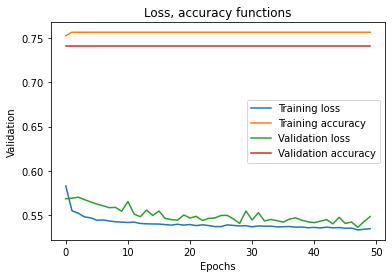

In [40]:
plt.plot(range(len(fit.history['loss'])), fit.history['loss'], label = 'Training loss')
plt.plot(range(len(fit.history['accuracy'])), fit.history['accuracy'], label = 'Training accuracy')

plt.plot(range(len(fit.history['val_loss'])), fit.history['val_loss'], label = 'Validation loss')
plt.plot(range(len(fit.history['val_accuracy'])), fit.history['val_accuracy'], label = 'Validation accuracy')

plt.legend()
plt.title('Loss, accuracy functions')
plt.xlabel('Epochs')
plt.ylabel('Validation')

This encoding appears to function better on this data set than using [-0.5, 0.5], although validation accuracy is still slightly lower than it was previously. The encoding that works the best is still [0,1] on the augmented data.